## Main code

In [150]:
import scipy
import scipy.linalg as linalg
import numpy as np
!pip install igraph
import igraph as ig
import random
import seaborn as sns
from matplotlib import pyplot as plt


In [266]:
class NOTEARS:
  def __init__(self, weight_threshold, max_rho, max_iter, h_tol, lambda1, originalMethod = False):
    self.X = None
    self.weight_threshold = weight_threshold
    self.max_rho = max_rho
    self.max_iter = max_iter
    self.h_tol = h_tol
    self.lambda1 = lambda1
    self.rho = 1.0
    self.alpha = 1.0
    self.h = np.inf
    self.originalMethod = originalMethod
    self.b = 1.5

  def calc_h(self, W_flattened):
    d = self.X.shape[1]
    #W = W_flattened.reshape([d, d])
    W = self._adj(W_flattened)
    M = linalg.expm(W*W)
    h = np.trace(M) - d
    h_grad = 2* M.T * W
    return h, h_grad


  # Doesn't include regularization term
  def objective_and_gradient(self, W_flattened):
      d = self.X.shape[1]
      n = self.X.shape[0]

      #W = W_flattened.reshape([d, d])
      W = self._adj(W_flattened)

      # Just lasso regression loss
      R = self.X - self.X @ W
      loss = 1/(2*n) * (R**2).sum()
      grad_loss = -1.0/n * self.X.T @ R
      h, h_grad = self.calc_h(W_flattened)

      #objective_value = loss + self.rho/2 * h**2 + self.alpha*h
      #objective_gradient = grad_loss + (self.rho * h + self.alpha) * h_grad
      #objective_gradient = np.concatenate((objective_gradient + self.lambda1, []), axis=None)

      objective_value = loss + self.rho/2 * h**2 + self.alpha*h + self.lambda1*np.abs(W).sum()
      objective_gradient = grad_loss + (self.rho * h + self.alpha) * h_grad
      objective_gradient = np.concatenate((objective_gradient + self.lambda1, - objective_gradient + self.lambda1), axis=None)
      return objective_value, objective_gradient

  def _adj(self, w):
        """Convert doubled variables ([2 d^2] array) back to original variables ([d, d] matrix)."""
        # Note doubled variables are for handling non-smooth regularization term
        return (w[:d * d] - w[d * d:]).reshape([d, d])


  def solve(self):
      d = self.X.shape[1]
      n = self.X.shape[0]
      # Starting guess for W; initialize rho, alpha
      W_est_flattened, self.rho, self.alpha = np.zeros(2*d*d), 1.0, 0.0
      rho_s = []
      alphas = []

      # Set bounds for W_est matrix (basically diagonal elements must be zero.)
      #bnds = [(0, 0) if i == j else (0, None) for i in range(d) for j in range(d)]
      bnds = [(0, 0) if i == j else (0, None) for _ in range(2) for i in range(d) for j in range(d)]

      # Perform Dual Gradient ascent to solve eq. (12) in paper
      if self.originalMethod:
              # Perform Dual Gradient ascent to solve eq. (12) in paper
          # Perform Dual Gradient ascent to solve eq. (12) in paper
          for i in range(1, self.max_iter, 1):
              rho_s.append(self.rho)
              alphas.append(self.alpha)
              print("Iteration " + str(i))

              while self.rho < self.max_rho:
                  W_next_flattened = scipy.optimize.minimize(self.objective_and_gradient, W_est_flattened, method='L-BFGS-B', jac=True, bounds = bnds).x
                  #print(W_next_flattened)
                  h_next, _ = self.calc_h(W_next_flattened)
                  #print(h_next)
                  if h_next > 0.25*self.h: self.rho*= 10
                  else: break

              W_est_flattened = W_next_flattened
              self.h = h_next
              self.alpha = self.alpha + self.rho*self.h
              print(self.h)
              #print(W_est_flattened.reshape([d, d]))

              if self.h <= self.h_tol or self.rho >= self.max_rho: break
          # Threshold values lower than weight_threshold (omega)
          #W_est = W_est_flattened.reshape([d, d])
          W_est = self._adj(W_est_flattened)
          W_est[np.abs(W_est)< self.weight_threshold] = 0
          assert self.is_dag(W_est)
          np.savetxt('W_est.csv', W_est, delimiter=',')


          accuracy = self.count_accuracy(B_true, W_est != 0)
          print(accuracy)

      else:
        h_vals = []
        h_init, _ = self.calc_h(W_est_flattened)
        #curr_h = h_init
        factor = 1
        alpha_init = self.alpha
        i = 1
        for iter in range(1, self.max_iter, 1):
            # Update rho
            self.rho = factor * self.b**i
            # Update tolerance
            epsilon_i = (1/self.rho)**0.25#**0.025
            rho_s.append(self.rho)
            alphas.append(self.alpha)
            print("Iteration " + str(iter))

            while self.rho < self.max_rho:
                  i+=1
                  W_next_flattened = scipy.optimize.minimize(self.objective_and_gradient, W_est_flattened, method='L-BFGS-B', jac=True, bounds = bnds, options = {'gtol' : epsilon_i }).x
                  #print(W_next_flattened)
                  h_next, _ = self.calc_h(W_next_flattened)
                  if h_next > 0.25*self.h:
                    factor*= 10
                    # Update rho
                    self.rho = factor * self.b**i
                    # Update tolerance
                    epsilon_i = (1/self.rho)**0.25
                  else: break

            #W_next_flattened = scipy.optimize.minimize(self.objective_and_gradient,
            #                                           W_est_flattened, method='L-BFGS-B', jac=True, bounds = bnds, options = {'gtol' : epsilon_i }).x
            #h_next, _ = self.calc_h(W_next_flattened)
            print(h_next)

            W_est_flattened = W_next_flattened
            self.h = h_next


            #Update alpha
            dual_step_size = self.rho*np.minimum(1, 1*np.log(2)**2/(self.h*(i+1)*np.log(i+2)**2))
            #self.alpha = self.alpha + self.rho*self.h
            self.alpha = self.alpha + dual_step_size*self.h
            i+=1


            if self.h <= self.h_tol or self.rho >= self.max_rho:
              self.rho = self.max_rho
              W_est_flattened = scipy.optimize.minimize(self.objective_and_gradient, W_est_flattened, method='L-BFGS-B', jac=True, bounds = bnds).x
              self.h, _ = self.calc_h(W_next_flattened)
              break

        # Threshold values lower than weight_threshold (omega)
        W_est = self._adj(W_est_flattened)
        W_est[np.abs(W_est)< self.weight_threshold] = 0
        assert self.is_dag(W_est)
        np.savetxt('W_est.csv', W_est, delimiter=',')


        accuracy = self.count_accuracy(B_true, W_est != 0)
        print(accuracy)

      print(self.objective_and_gradient)
      return W_est, rho_s, alphas, accuracy


  ### Helper functions to generate/simulate DAG (i.e. our synthetic data) (copied from NOTEARS code)
  def is_dag(self, W):
    G = ig.Graph.Weighted_Adjacency(W.tolist())
    return G.is_dag()

  def simulate_parameter(self, B, w_ranges=((-2.0, -0.5), (0.5, 2.0))):
    """Simulate SEM parameters for a DAG.

    Args:
        B (np.ndarray): [d, d] binary adj matrix of DAG
        w_ranges (tuple): disjoint weight ranges

    Returns:
        W (np.ndarray): [d, d] weighted adj matrix of DAG
    """
    W = np.zeros(B.shape)
    S = np.random.randint(len(w_ranges), size=B.shape)  # which range
    for i, (low, high) in enumerate(w_ranges):
        U = np.random.uniform(low=low, high=high, size=B.shape)
        W += B * (S == i) * U
    return W


  def simulate_dag(self, d, s0, graph_type):
      """Simulate random DAG with some expected number of edges.

      Args:
          d (int): num of nodes
          s0 (int): expected num of edges
          graph_type (str): ER, SF, BP

      Returns:
          B (np.ndarray): [d, d] binary adj matrix of DAG
      """
      def _random_permutation(M):
          # np.random.permutation permutes first axis only
          P = np.random.permutation(np.eye(M.shape[0]))
          return P.T @ M @ P

      def _random_acyclic_orientation(B_und):
          return np.tril(_random_permutation(B_und), k=-1)

      def _graph_to_adjmat(G):
          return np.array(G.get_adjacency().data)

      if graph_type == 'ER':
          # Erdos-Renyi
          G_und = ig.Graph.Erdos_Renyi(n=d, m=s0)
          B_und = _graph_to_adjmat(G_und)
          B = _random_acyclic_orientation(B_und)
      elif graph_type == 'SF':
          # Scale-free, Barabasi-Albert
          G = ig.Graph.Barabasi(n=d, m=int(round(s0 / d)), directed=True)
          B = _graph_to_adjmat(G)
      elif graph_type == 'BP':
          # Bipartite, Sec 4.1 of (Gu, Fu, Zhou, 2018)
          top = int(0.2 * d)
          G = ig.Graph.Random_Bipartite(top, d - top, m=s0, directed=True, neimode=ig.OUT)
          B = _graph_to_adjmat(G)
      else:
          raise ValueError('unknown graph type')
      B_perm = _random_permutation(B)
      assert ig.Graph.Adjacency(B_perm.tolist()).is_dag()
      return B_perm

  def simulate_linear_sem(self, W, n, sem_type, noise_scale=None):
      """Simulate samples from linear SEM with specified type of noise.

      For uniform, noise z ~ uniform(-a, a), where a = noise_scale.

      Args:
          W (np.ndarray): [d, d] weighted adj matrix of DAG
          n (int): num of samples, n=inf mimics population risk
          sem_type (str): gauss, exp, gumbel, uniform, logistic, poisson
          noise_scale (np.ndarray): scale parameter of additive noise, default all ones

      Returns:
          X (np.ndarray): [n, d] sample matrix, [d, d] if n=inf
      """
      def _simulate_single_equation(X, w, scale):
          """X: [n, num of parents], w: [num of parents], x: [n]"""
          if sem_type == 'gauss':
              z = np.random.normal(scale=scale, size=n)
              x = X @ w + z
          elif sem_type == 'exp':
              z = np.random.exponential(scale=scale, size=n)
              x = X @ w + z
          elif sem_type == 'gumbel':
              z = np.random.gumbel(scale=scale, size=n)
              x = X @ w + z
          elif sem_type == 'uniform':
              z = np.random.uniform(low=-scale, high=scale, size=n)
              x = X @ w + z
          elif sem_type == 'logistic':
              x = np.random.binomial(1, scipy.special.expit(X @ w)) * 1.0
          elif sem_type == 'poisson':
              x = np.random.poisson(np.exp(X @ w)) * 1.0
          else:
              raise ValueError('unknown sem type')
          return x

      d = W.shape[0]
      if noise_scale is None:
          scale_vec = np.ones(d)
      elif np.isscalar(noise_scale):
          scale_vec = noise_scale * np.ones(d)
      else:
          if len(noise_scale) != d:
              raise ValueError('noise scale must be a scalar or has length d')
          scale_vec = noise_scale
      if not self.is_dag(W):
          raise ValueError('W must be a DAG')
      if np.isinf(n):  # population risk for linear gauss SEM
          if sem_type == 'gauss':
              # make 1/d X'X = true cov
              X = np.sqrt(d) * np.diag(scale_vec) @ np.linalg.inv(np.eye(d) - W)
              return X
          else:
              raise ValueError('population risk not available')
      # empirical risk
      G = ig.Graph.Weighted_Adjacency(W.tolist())
      ordered_vertices = G.topological_sorting()
      assert len(ordered_vertices) == d
      X = np.zeros([n, d])
      for j in ordered_vertices:
          parents = G.neighbors(j, mode=ig.IN)
          X[:, j] = _simulate_single_equation(X[:, parents], W[parents, j], scale_vec[j])
      return X

  def count_accuracy(self, B_true, B_est):
    """Compute various accuracy metrics for B_est.

    true positive = predicted association exists in condition in correct direction
    reverse = predicted association exists in condition in opposite direction
    false positive = predicted association does not exist in condition

    Args:
        B_true (np.ndarray): [d, d] ground truth graph, {0, 1}
        B_est (np.ndarray): [d, d] estimate, {0, 1, -1}, -1 is undirected edge in CPDAG

    Returns:
        fdr: (reverse + false positive) / prediction positive
        tpr: (true positive) / condition positive
        fpr: (reverse + false positive) / condition negative
        shd: undirected extra + undirected missing + reverse
        nnz: prediction positive
    """
    if (B_est == -1).any():  # cpdag
        if not ((B_est == 0) | (B_est == 1) | (B_est == -1)).all():
            raise ValueError('B_est should take value in {0,1,-1}')
        if ((B_est == -1) & (B_est.T == -1)).any():
            raise ValueError('undirected edge should only appear once')
    else:  # dag
        if not ((B_est == 0) | (B_est == 1)).all():
            raise ValueError('B_est should take value in {0,1}')
        if not self.is_dag(B_est):
            raise ValueError('B_est should be a DAG')
    d = B_true.shape[0]
    # linear index of nonzeros
    pred_und = np.flatnonzero(B_est == -1)
    pred = np.flatnonzero(B_est == 1)
    cond = np.flatnonzero(B_true)
    cond_reversed = np.flatnonzero(B_true.T)
    cond_skeleton = np.concatenate([cond, cond_reversed])
    # true pos
    true_pos = np.intersect1d(pred, cond, assume_unique=True)
    # treat undirected edge favorably
    true_pos_und = np.intersect1d(pred_und, cond_skeleton, assume_unique=True)
    true_pos = np.concatenate([true_pos, true_pos_und])
    # false pos
    false_pos = np.setdiff1d(pred, cond_skeleton, assume_unique=True)
    false_pos_und = np.setdiff1d(pred_und, cond_skeleton, assume_unique=True)
    false_pos = np.concatenate([false_pos, false_pos_und])
    # reverse
    extra = np.setdiff1d(pred, cond, assume_unique=True)
    reverse = np.intersect1d(extra, cond_reversed, assume_unique=True)
    # compute ratio
    pred_size = len(pred) + len(pred_und)
    cond_neg_size = 0.5 * d * (d - 1) - len(cond)
    fdr = float(len(reverse) + len(false_pos)) / max(pred_size, 1)
    tpr = float(len(true_pos)) / max(len(cond), 1)
    fpr = float(len(reverse) + len(false_pos)) / max(cond_neg_size, 1)
    # structural hamming distance
    pred_lower = np.flatnonzero(np.tril(B_est + B_est.T))
    cond_lower = np.flatnonzero(np.tril(B_true + B_true.T))
    extra_lower = np.setdiff1d(pred_lower, cond_lower, assume_unique=True)
    missing_lower = np.setdiff1d(cond_lower, pred_lower, assume_unique=True)
    shd = len(extra_lower) + len(missing_lower) + len(reverse)
    return {'fdr': fdr, 'tpr': tpr, 'fpr': fpr, 'shd': shd, 'nnz': pred_size}

Sample test run

In [275]:
solver = NOTEARS(weight_threshold= 0.1, max_rho= 1e16, max_iter= 100, h_tol= 1e-8, lambda1= 0.1, originalMethod = True)
n, d, s0, graph_type, sem_type = 500, 20, 40, 'ER', 'gauss'
solver.d = d
B_true = solver.simulate_dag(d, s0, graph_type)
W_true = solver.simulate_parameter(B_true)
np.savetxt('W_true.csv', W_true, delimiter=',')

solver.X = solver.simulate_linear_sem(W_true, n, sem_type)
np.savetxt('X.csv', solver.X, delimiter=',')

In [276]:
%%time
W_est, rhos, alphas, _ = solver.solve()

Iteration 1
0.9383001584625852
Iteration 2
0.09696212793236825
Iteration 3
0.02137097285746492
Iteration 4
0.00481830166503272
Iteration 5
0.00034720823841283277
Iteration 6
8.409971261613691e-05
Iteration 7
3.1852198461024273e-06
Iteration 8
6.114340038720911e-07
Iteration 9
6.60775114624812e-08
Iteration 10
1.5349428394983988e-08
Iteration 11
1.154042195139482e-09
{'fdr': 0.047619047619047616, 'tpr': 1.0, 'fpr': 0.013333333333333334, 'shd': 2, 'nnz': 42}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x7fa75983d7e0>>
CPU times: user 9.46 s, sys: 9.72 s, total: 19.2 s
Wall time: 14 s


In [277]:
solver2 = NOTEARS(weight_threshold= 0.1, max_rho= 1e16, max_iter= 100, h_tol= 1e-8, lambda1= 0.1, originalMethod = False)
solver2.d = d
solver2.X = solver.X

In [278]:
%%time
W_est_new_ours, rhos_ours, alphas_ours, _ = solver2.solve()

Iteration 1
0.9511614816899012
Iteration 2
0.17368598780403843
Iteration 3
0.019954556124542222
Iteration 4
0.002058553189382195
Iteration 5
0.00018533233015105566
Iteration 6
2.1012212187088153e-05
Iteration 7
1.8583314904674353e-06
Iteration 8
2.698074830220776e-07
Iteration 9
4.1896981883837725e-08
Iteration 10
5.3692446044806275e-09
{'fdr': 0.047619047619047616, 'tpr': 1.0, 'fpr': 0.013333333333333334, 'shd': 2, 'nnz': 42}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x7fa760138340>>
CPU times: user 5.78 s, sys: 5.05 s, total: 10.8 s
Wall time: 6.99 s


Text(0.5, 0, 'Iteration')

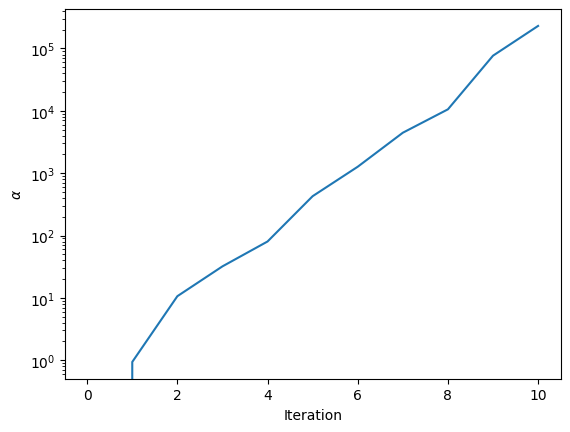

In [279]:
import matplotlib.pyplot as plt
plt.semilogy(alphas)
plt.ylabel(r'$\alpha$')
plt.xlabel('Iteration')


Text(0.5, 0, 'Iteration')

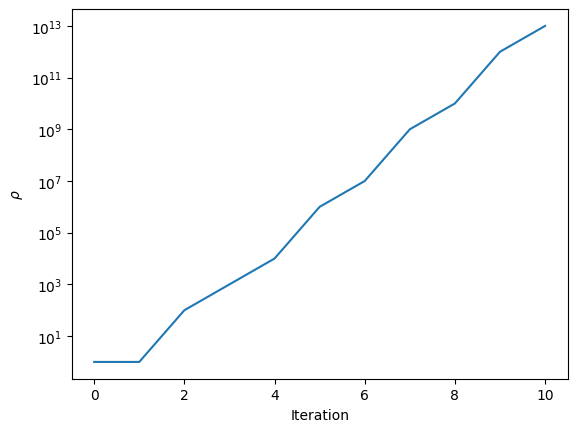

In [280]:
plt.semilogy(rhos)
plt.ylabel(r'$\rho$')
plt.xlabel('Iteration')

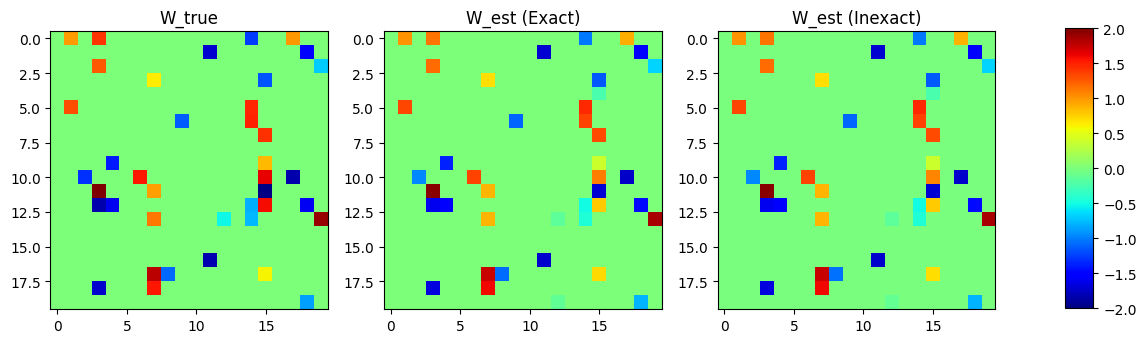

In [281]:
import matplotlib.pyplot as plt
sns.reset_orig()

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14,4))

#for ax in axes.flat:
im = ax1.imshow(W_true, vmin=-2, vmax=2, cmap='jet')
ax1.set_title('W_true')
im = ax2.imshow(W_est, vmin=-2, vmax=2, cmap='jet')
ax2.set_title('W_est (Exact)')
im = ax3.imshow(W_est_new_ours, vmin=-2, vmax=2, cmap='jet')
ax3.set_title('W_est (Inexact)')


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

## Plots/Simulations with Synthetic Data

ER, exp, 5
Starting Exact Method
Iteration 1
0.47586241518640726
Iteration 2
0.058303561012953864
Iteration 3
0.014194169687091751
Iteration 4
0.000867112524593594
Iteration 5
0.00016332859050827153
Iteration 6
3.3300107304512494e-05
Iteration 7
1.6660830741699328e-06
Iteration 8
3.923981362063955e-07
Iteration 9
7.677505031722376e-08
{'fdr': 0.375, 'tpr': 1.0, 'fpr': 0.6, 'shd': 3, 'nnz': 8}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x7fa758067250>>
Starting Inexact Method
Iteration 1
0.29991073792761114
Iteration 2
0.02187111100388428
Iteration 3
0.0030054218523343224
Iteration 4
0.0007195360028973141
Iteration 5
0.0001231577597469169
Iteration 6
1.1510169785289293e-05
Iteration 7
2.613565879272528e-07
Iteration 8
2.315162372923396e-08
{'fdr': 0.4444444444444444, 'tpr': 1.0, 'fpr': 0.8, 'shd': 4, 'nnz': 9}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x7fa75926d6f0>>
ER, exp, 10
Starting Exact Method
Iteration 1
0.48701

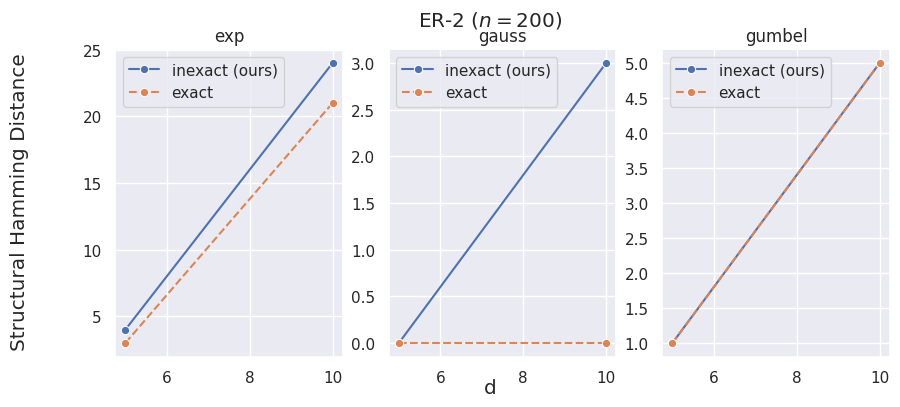

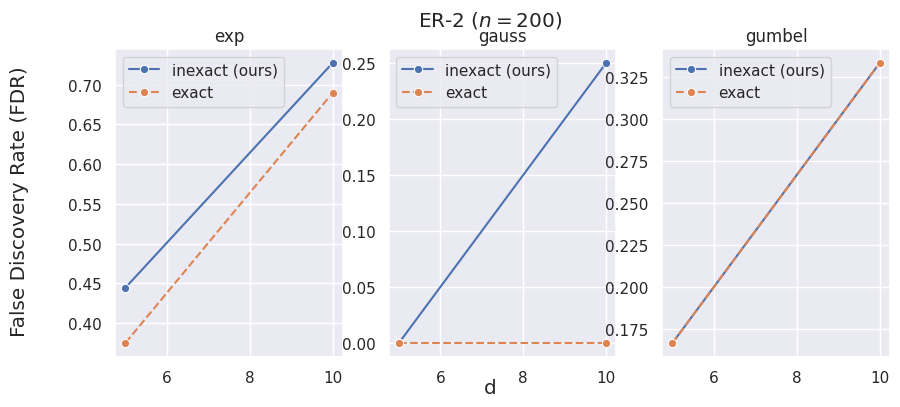

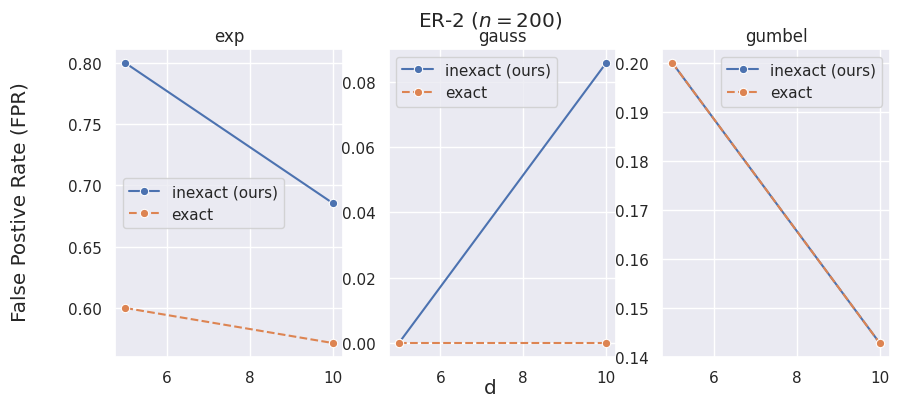

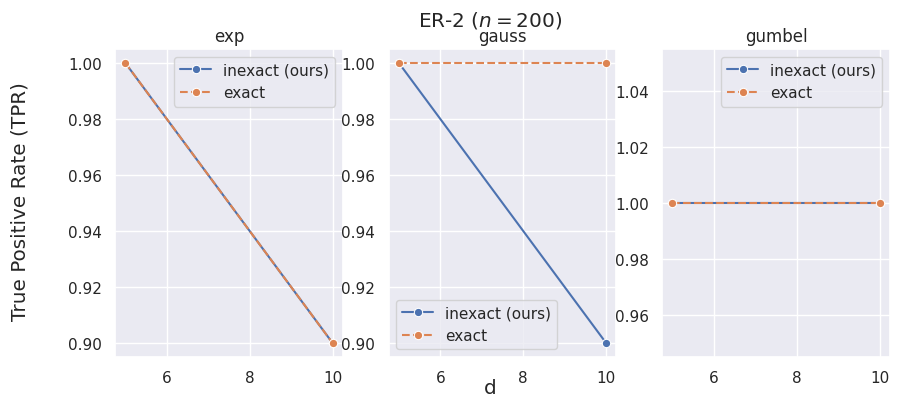

In [261]:
sns.set() # Setting seaborn as default style even if use only matplotlib
plt.show()

random.seed(1)
np.random.seed(1)
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(10,4))
fig.suptitle(r'ER-2 ($n = 200$)')
fig.supylabel('Structural Hamming Distance')
fig.supxlabel('d')
#axes[0, 0].set_title('exp')
#axes[0, 1].set_title('gauss')
#axes[0, 2].set_title('gumbel')
axes[0].set_title('exp')
axes[1].set_title('gauss')
axes[2].set_title('gumbel')

figFDR, axesFDR = plt.subplots(1, 3, sharex=True, figsize=(10,4))
figFDR.suptitle('ER-2 ($n = 200$)')
figFDR.supylabel('False Discovery Rate (FDR)')
figFDR.supxlabel('d')
axesFDR[0].set_title('exp')
axesFDR[1].set_title('gauss')
axesFDR[2].set_title('gumbel')

figFPR, axesFPR = plt.subplots(1, 3, sharex=True, figsize=(10,4))
figFPR.suptitle('ER-2 ($n = 200$)')
figFPR.supylabel('False Postive Rate (FPR)')
figFPR.supxlabel('d')
axesFPR[0].set_title('exp')
axesFPR[1].set_title('gauss')
axesFPR[2].set_title('gumbel')

figTPR, axesTPR = plt.subplots(1, 3, sharex=True, figsize=(10,4))
figTPR.suptitle('ER-2 ($n = 200$)')
figTPR.supylabel('True Positive Rate (TPR)')
figTPR.supxlabel('d')
axesTPR[0].set_title('exp')
axesTPR[1].set_title('gauss')
axesTPR[2].set_title('gumbel')

d_vals = [5, 10]


for graph_type in ['ER']:
    for noise_type in ['exp', 'gauss', 'gumbel']:
      for n in [200]:
        shd_results_original = []
        shd_results_ours = []
        fdr_results_original = []
        fdr_results_ours = []
        fpr_results_original = []
        fpr_results_ours = []
        tpr_results_original = []
        tpr_results_ours = []

        for d in d_vals:
            for i in np.arange(1):
              param_tuple = (graph_type, noise_type, str(d))
              print(", ".join(param_tuple))

              solver = NOTEARS(weight_threshold= 0.1, max_rho= 1e16, max_iter= 100, h_tol= 1e-7, lambda1= 0.1, originalMethod = True)
              if graph_type == 'ER':
                n, d, s0, graph_type, sem_type = n, d, d, graph_type, noise_type
              if graph_type == 'SF':
                n, d, s0, graph_type, sem_type = n, d, 4*d, graph_type, noise_type
              solver.d = d
              B_true = solver.simulate_dag(d, s0, graph_type)
              W_true = solver.simulate_parameter(B_true)
              np.savetxt('W_true.csv', W_true, delimiter=',')


              solver.X = solver.simulate_linear_sem(W_true, n, sem_type)
              np.savetxt('X.csv', solver.X, delimiter=',')

              print('Starting Exact Method')
              W_est_new, rhos, alphas, accuracy = solver.solve()
              shd_results_original.append(accuracy["shd"])
              fdr_results_original.append(accuracy["fdr"])
              tpr_results_original.append(accuracy["tpr"])
              fpr_results_original.append(accuracy["fpr"])

              solver2 = NOTEARS(weight_threshold= 0.1, max_rho= 1e16, max_iter= 100, h_tol= 1e-7, lambda1= 0.1, originalMethod = False)
              solver2.d = d
              solver2.X = solver.X

              #%%time
              print('Starting Inexact Method')
              W_est_new_ours, rhos_ours, alphas_ours, accuracy_ours = solver2.solve()
              shd_results_ours.append(accuracy_ours["shd"])
              fdr_results_ours.append(accuracy_ours["fdr"])
              tpr_results_ours.append(accuracy_ours["tpr"])
              fpr_results_ours.append(accuracy_ours["fpr"])

        if noise_type == 'exp' and graph_type == 'ER':
          sns.lineplot(ax=axes[0], x=d_vals, y=shd_results_ours, label= 'inexact (ours)', marker="o")
          sns.lineplot(ax=axes[0], x=d_vals, y=shd_results_original, label = 'exact', marker="o", linestyle = '--')
          sns.lineplot(ax=axesFDR[0], x=d_vals, y=fdr_results_ours, label= 'inexact (ours)', marker="o")
          sns.lineplot(ax=axesFDR[0], x=d_vals, y=fdr_results_original, label = 'exact', marker="o", linestyle = '--')
          sns.lineplot(ax=axesFPR[0], x=d_vals, y=fpr_results_ours, label= 'inexact (ours)', marker="o")
          sns.lineplot(ax=axesFPR[0], x=d_vals, y=fpr_results_original, label = 'exact', marker="o", linestyle = '--')
          sns.lineplot(ax=axesTPR[0], x=d_vals, y=tpr_results_ours, label= 'inexact (ours)', marker="o")
          sns.lineplot(ax=axesTPR[0], x=d_vals, y=tpr_results_original, label = 'exact', marker="o", linestyle = '--')


        if noise_type == 'gauss' and graph_type == 'ER':
          sns.lineplot(ax=axes[1], x=d_vals, y=shd_results_ours, label= 'inexact (ours)', marker="o")
          sns.lineplot(ax=axes[1], x=d_vals, y=shd_results_original, label = 'exact', marker="o", linestyle = '--')
          sns.lineplot(ax=axesFDR[1], x=d_vals, y=fdr_results_ours, label= 'inexact (ours)', marker="o")
          sns.lineplot(ax=axesFDR[1], x=d_vals, y=fdr_results_original, label = 'exact', marker="o", linestyle = '--')
          sns.lineplot(ax=axesFPR[1], x=d_vals, y=fpr_results_ours, label= 'inexact (ours)', marker="o")
          sns.lineplot(ax=axesFPR[1], x=d_vals, y=fpr_results_original, label = 'exact', marker="o", linestyle = '--')
          sns.lineplot(ax=axesTPR[1], x=d_vals, y=tpr_results_ours, label= 'inexact (ours)', marker="o")
          sns.lineplot(ax=axesTPR[1], x=d_vals, y=tpr_results_original, label = 'exact', marker="o", linestyle = '--')

        if noise_type == 'gumbel' and graph_type == 'ER':
          sns.lineplot(ax=axes[2], x=d_vals, y=shd_results_ours, label= 'inexact (ours)', marker="o")
          sns.lineplot(ax=axes[2], x=d_vals, y=shd_results_original, label = 'exact', marker="o", linestyle = '--')
          sns.lineplot(ax=axesFDR[2], x=d_vals, y=fdr_results_ours, label= 'inexact (ours)', marker="o")
          sns.lineplot(ax=axesFDR[2], x=d_vals, y=fdr_results_original, label = 'exact', marker="o", linestyle = '--')
          sns.lineplot(ax=axesFPR[2], x=d_vals, y=fpr_results_ours, label= 'inexact (ours)', marker="o")
          sns.lineplot(ax=axesFPR[2], x=d_vals, y=fpr_results_original, label = 'exact', marker="o", linestyle = '--')
          sns.lineplot(ax=axesTPR[2], x=d_vals, y=tpr_results_ours, label= 'inexact (ours)', marker="o")
          sns.lineplot(ax=axesTPR[2], x=d_vals, y=tpr_results_original, label = 'exact', marker="o", linestyle = '--')

        '''
        if noise_type == 'exp' and graph_type == 'SF':
          sns.lineplot(ax=axes[1, 0], x=d_vals, y=shd_results_original, label = 'exact', marker="o")
          sns.lineplot(ax=axes[1, 0], x=d_vals, y=shd_results_ours, label= 'inexact (ours)', marker="o")

        if noise_type == 'gauss' and graph_type == 'SF':
          sns.lineplot(ax=axes[1, 1], x=d_vals, y=shd_results_original, label = 'exact', marker="o")
          sns.lineplot(ax=axes[1, 1], x=d_vals, y=shd_results_ours, label= 'inexact (ours)', marker="o")

        if noise_type == 'gumbel' and graph_type == 'SF':
          sns.lineplot(ax=axes[1, 2], x=d_vals, y=shd_results_original, label = 'exact', marker="o")
          sns.lineplot(ax=axes[1, 2], x=d_vals, y=shd_results_ours, label= 'inexact (ours)', marker="o")
        '''


#fig.legend()

## Using real data

Exact Method

In [282]:
solver = NOTEARS(weight_threshold= 0.1, max_rho= 1e16, max_iter= 100, h_tol= 1e-8, lambda1= 0.1, originalMethod = True)
n, d, s0, graph_type, sem_type = 7466, 11, 35, 'ER', 'gauss'
solver.d = d
B_true = solver.simulate_dag(d, s0, graph_type)
W_true = solver.simulate_parameter(B_true)
np.savetxt('W_true.csv', W_true, delimiter=',')

solver.X = np.nan_to_num(np.load('Sachs.npy'))

In [283]:
%%time
random.seed(1)
np.random.seed(1)
W_est, rhos, alphas, _ = solver.solve()

Iteration 1
2.777144045482446
Iteration 2
0.310446447565484
Iteration 3
0.07052444158863835
Iteration 4
0.015556087401105145
Iteration 5
0.003521536643987133
Iteration 6
0.0008236247270012598
Iteration 7
0.00020517487908655596
Iteration 8
1.4567909371265841e-05
Iteration 9
2.788024913158438e-06
Iteration 10
4.813155776162148e-07
Iteration 11
1.1124227228265227e-07
Iteration 12
6.849813516396352e-08
{'fdr': 0.41025641025641024, 'tpr': 0.6571428571428571, 'fpr': 0.8, 'shd': 23, 'nnz': 39}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x7fa75974a470>>
CPU times: user 43.9 s, sys: 46.4 s, total: 1min 30s
Wall time: 1min 1s


Inexact Method (ours)

In [284]:
solver2 = NOTEARS(weight_threshold= 0.1, max_rho= 1e16, max_iter= 100, h_tol= 1e-8, lambda1= 0.1, originalMethod = False)
solver2.d = d
solver2.X = solver.X
random.seed(1)
np.random.seed(1)

In [285]:
%%time
W_est_new_ours, rhos_ours, alphas_ours, _ = solver2.solve()

Iteration 1
2.7761087331245733
Iteration 2
0.2358694744499541
Iteration 3
0.029924263498672943
Iteration 4
0.0031466656041843066
Iteration 5
0.000306368262890544
Iteration 6
3.7721298497217504e-05
Iteration 7
3.7908656036478305e-06
Iteration 8
4.705682172811976e-07
Iteration 9
8.666899375953108e-08
Iteration 10
8.666899375953108e-08
{'fdr': 0.4358974358974359, 'tpr': 0.6285714285714286, 'fpr': 0.85, 'shd': 25, 'nnz': 39}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x7fa7590d7310>>
CPU times: user 34.7 s, sys: 32.1 s, total: 1min 6s
Wall time: 39.7 s
